In [1]:
# Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
#import pyLDAvis.gensim
#import gensim
#from wordcloud import WordCloud, STOPWORDS

from collections import defaultdict, Counter
import string
from sklearn.feature_extraction.text import CountVectorizer


%matplotlib inline

In [2]:
# load train data
train = pd.read_csv('train.csv')
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
# replace na
train['text'] = train['text'].fillna(train['title'])
train['title'] = train['title'].fillna(train['text'])

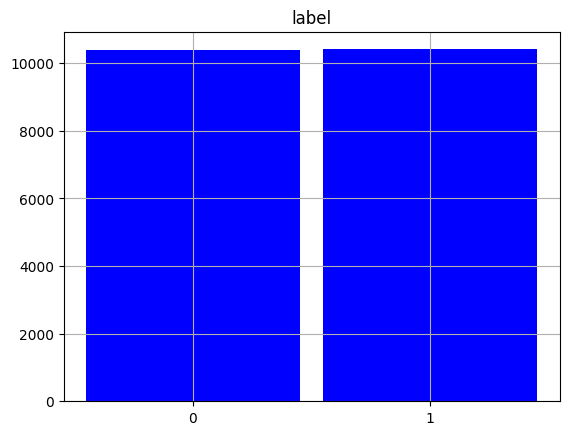

In [4]:
# Class balance analysis
train[['label']].hist(bins = 3)
plt.bar(np.arange(len([0,1])), train.groupby(['label']).size().values, 0.9,  color="blue")
plt.xticks(np.arange(len([0,1])), [0,1])
plt.show()

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

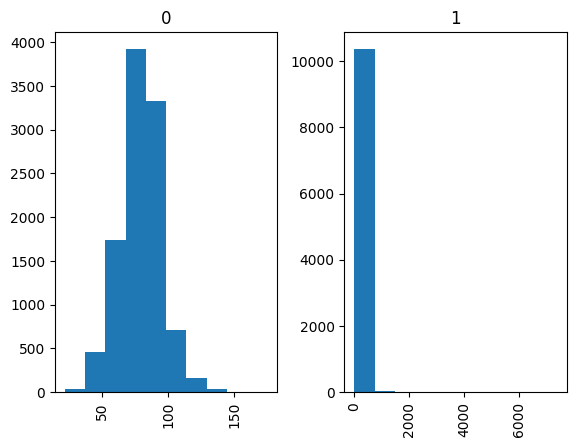

In [5]:
#  the number of characters present in each title by labels
train['title'].str.len().hist(by=train['label'])

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

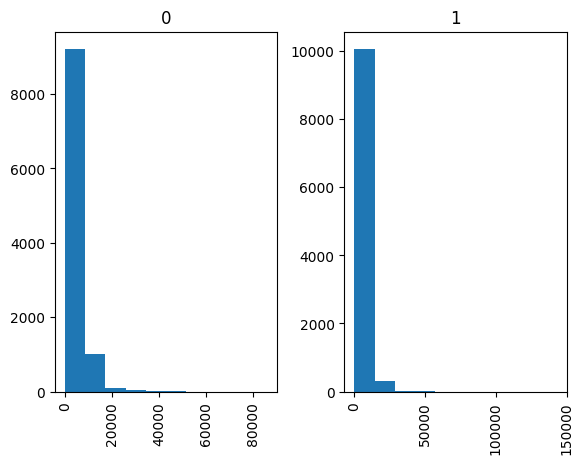

In [6]:
#  the number of characters present in each text by labels
train['text'].str.len().hist(by=train['label'])

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

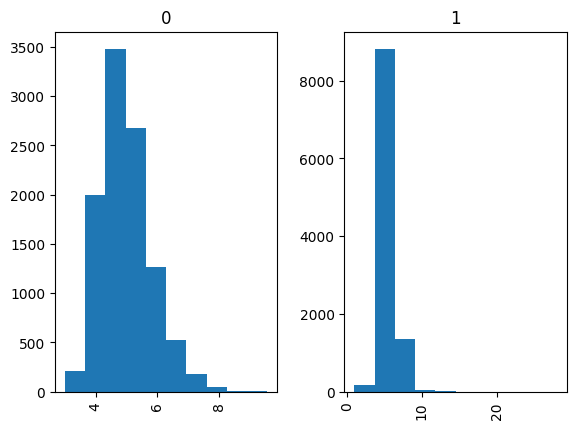

In [7]:
# Word level analysis of title
# Remove rows with missing values in the 'title' column
train_cleaned = train.dropna(subset=['title'])

# Word level analysis of title
train_cleaned['title'].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).hist(by=train_cleaned['label'])

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

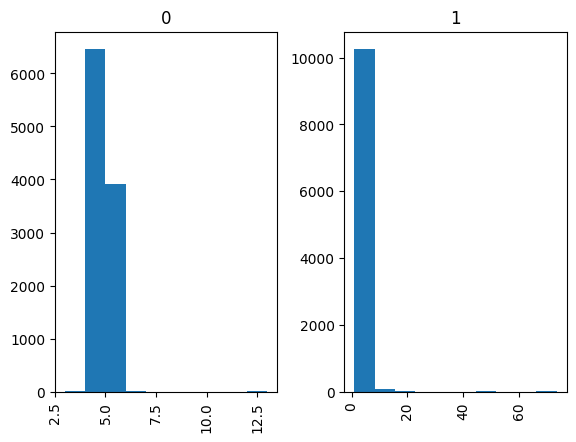

In [8]:
# Word level analysis of title
# Remove rows with missing values in the 'text' column
train_cleaned = train.dropna(subset=['text'])

# Word level analysis of text
train_cleaned['text'].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).hist(by=train_cleaned['label'])

In [9]:
# Remove stopwords from title and text by label
from wordcloud import WordCloud, STOPWORDS
messages_fake=train[train.label == 1].copy()
messages_not_fake=train[train.label == 0].copy()

<Axes: >

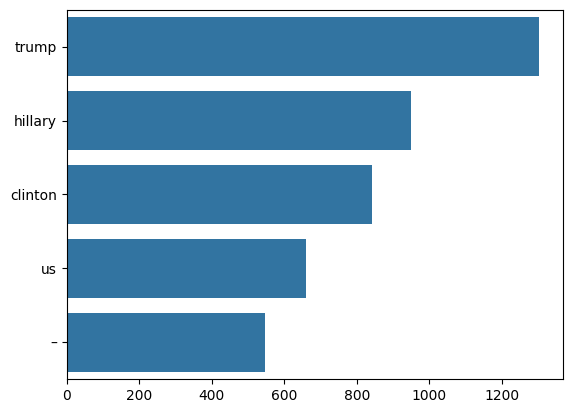

In [10]:
# Corpus analysis corpus_title_fake
stop=set(stopwords.words('english'))
messages_fake['title'] = messages_fake['title'].str.lower()
messages_fake['title'] = messages_fake.title.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = messages_fake['title'].str.split()
new=new.values.tolist()
corpus_title_fake=[word for i in new for word in i]

counter=Counter(corpus_title_fake)
most=counter.most_common()
x, y= [], []
for word,count in most[:25]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

<Axes: >

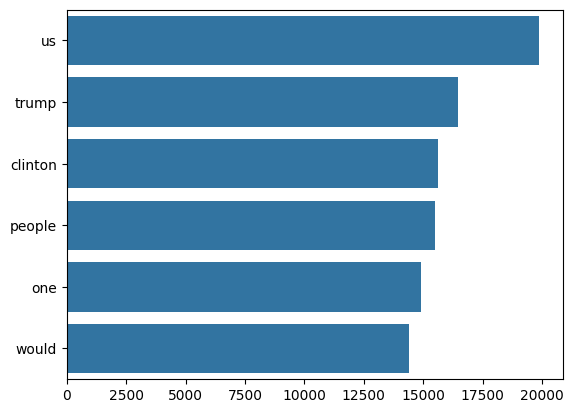

In [11]:
# Corpus analysis corpus_text_fake
stop=set(stopwords.words('english'))
messages_fake['text'] = messages_fake['text'].str.lower()
messages_fake['text'] = messages_fake.text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = messages_fake['text'].str.split()
new=new.values.tolist()
corpus_text_fake=[word for i in new for word in i]

counter=Counter(corpus_text_fake)
most=counter.most_common()
x, y= [], []
for word,count in most[:50]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

<Axes: >

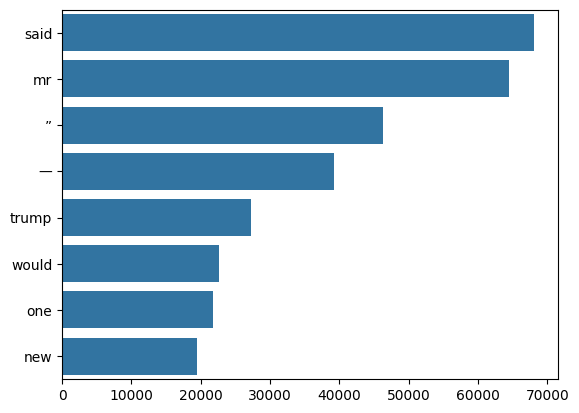

In [12]:
# Corpus analysis corpus_title_not_fake
stop=set(stopwords.words('english'))
messages_not_fake['title'] = messages_not_fake['text'].str.lower()
messages_not_fake['title'] = messages_not_fake.title.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = messages_not_fake['title'].str.split()
new=new.values.tolist()
corpus_title_not_fake=[word for i in new for word in i]

counter=Counter(corpus_title_not_fake)
most=counter.most_common()
x, y= [], []
for word,count in most[:50]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

<Axes: >

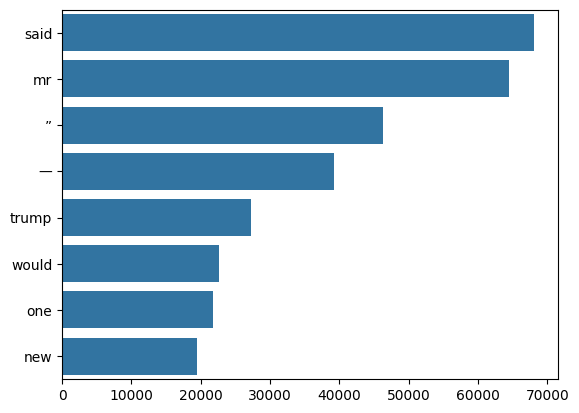

In [13]:
# Corpus analysis corpus_text_not_fake
stop=set(stopwords.words('english'))
messages_not_fake['text'] = messages_not_fake['text'].str.lower()
messages_not_fake['text'] = messages_not_fake.text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = messages_not_fake['text'].str.split()
new=new.values.tolist()
corpus_text_not_fake=[word for i in new for word in i]

counter=Counter(corpus_text_not_fake)
most=counter.most_common()
x, y= [], []
for word,count in most[:50]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [14]:
# Ngram analysis function

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<Axes: >

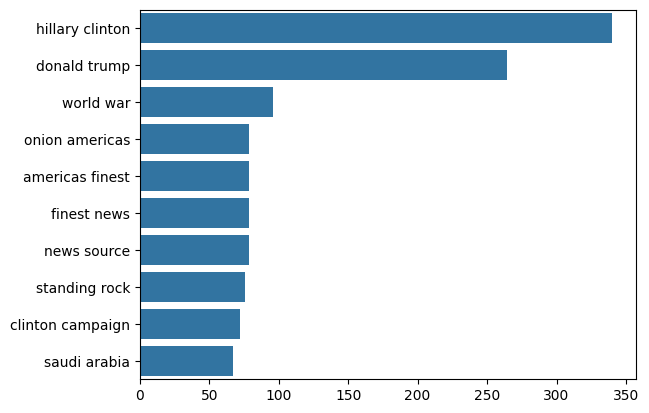

In [15]:
# Ngram analysis corpus_title_fake

messages_fake['title'] = messages_fake['title'].str.lower()
messages_fake['title'] = messages_fake.title.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
messages_fake['title'] = messages_fake['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_n_bigrams=get_top_ngram(messages_fake['title'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

<Axes: >

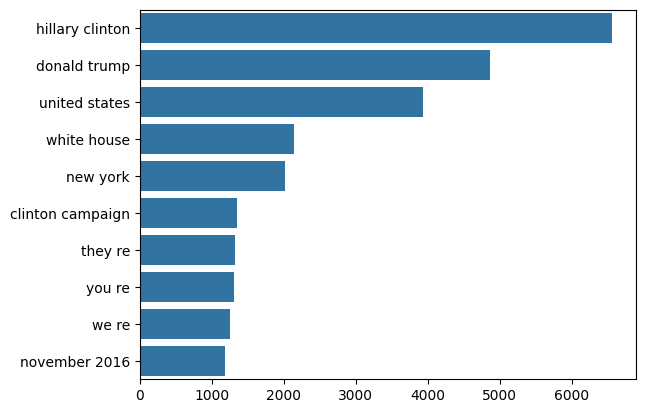

In [16]:
# Ngram analysis corpus_text_fake

messages_fake['text'] = messages_fake['text'].str.lower()
messages_fake['text'] = messages_fake.text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
messages_fake['text'] = messages_fake['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_n_bigrams=get_top_ngram(messages_fake['text'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

<Axes: >

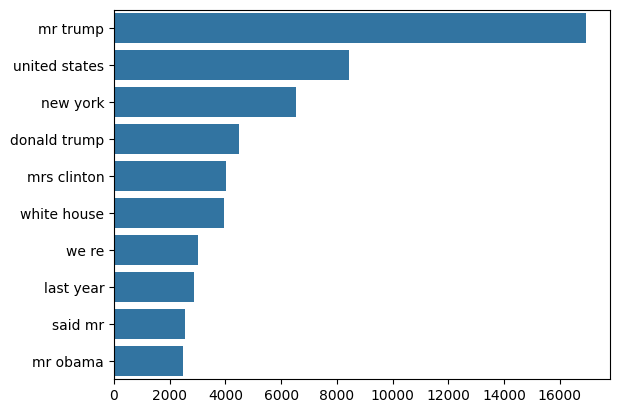

In [17]:
# Ngram analysis corpus_title_not_fake

messages_not_fake['title'] = messages_not_fake['title'].str.lower()
messages_not_fake['title'] = messages_not_fake.title.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
messages_not_fake['title'] = messages_not_fake['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_n_bigrams=get_top_ngram(messages_not_fake['title'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:1281: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


<Axes: >

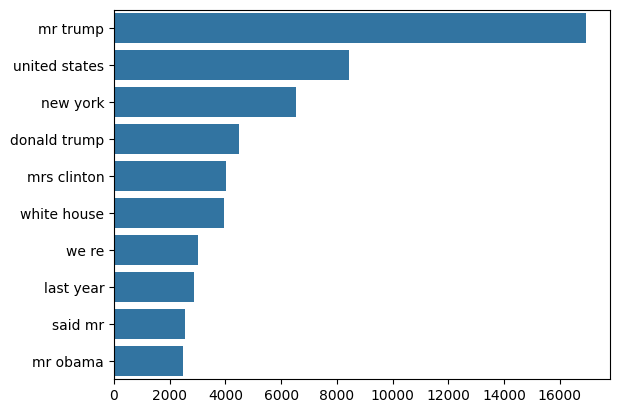

In [19]:
# Ngram analysis corpus_text_not_fake

messages_not_fake['text'] = messages_not_fake['text'].str.lower()
messages_not_fake['text'] = messages_not_fake.text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
messages_not_fake['text'] = messages_not_fake['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_n_bigrams=get_top_ngram(messages_not_fake['text'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

In [18]:
import pyLDAvis.gensim
import gensim
import nltk
from nltk.corpus import stopwords  # Import stopwords here
nltk.download('punkt')
nltk.download('wordnet')
# Download NLTK resources (do this once)

def preprocess_news(data, column_name):
  """Preprocess news data (replace with your actual implementation)

  Args:
      data: A DataFrame containing the news data
      column_name: The name of the column containing the news text

  Returns:
      A list of lists, where each inner list represents the preprocessed tokens
      from a news document.
  """
  stop = stopwords.words('english')  # Load stop words once
  corpus = []
  for news in data[column_name]:
    words = [w for w in nltk.word_tokenize(news) if (w not in stop)]  # Tokenize and remove stopwords
    # Add more preprocessing steps like lemmatization if needed
    corpus.append(words)
  return corpus

# Assuming messages_fake is a DataFrame with a 'title' column
corpus = preprocess_news(messages_fake, 'title')
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics=4, 
                                       id2word=dic, 
                                       passes=10,
                                       workers=2)

print(lda_model.show_topics())  # This should now display topics

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[(0, '0.020*"’" + 0.010*"trump" + 0.008*"news" + 0.007*"hillary" + 0.007*"us" + 0.006*"‘" + 0.005*"clinton" + 0.004*"new" + 0.004*"”" + 0.004*"“"'), (1, '0.017*"clinton" + 0.016*"’" + 0.015*"hillary" + 0.012*"fbi" + 0.010*"election" + 0.007*"new" + 0.006*"emails" + 0.006*"trump" + 0.005*"campaign" + 0.005*"–"'), (2, '0.009*"’" + 0.004*"trump" + 0.004*"–" + 0.003*"russian" + 0.003*"dakota" + 0.003*"comment" + 0.003*"video" + 0.003*"pipeline" + 0.003*"isis" + 0.003*"access"'), (3, '0.037*"’" + 0.024*"trump" + 0.020*"”" + 0.020*"“" + 0.012*"‘" + 0.009*"hillary" + 0.008*"us" + 0.007*"clinton" + 0.007*"war" + 0.006*"donald"')]


In [19]:
#Vizual for corpus_title_fake
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
pyLDAvis.save_html(vis, 'lda_fake_title.html')

In [20]:
#LDA for corpus_title_not_fake
corpus = preprocess_news(messages_not_fake,'title')
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
pyLDAvis.save_html(vis, 'lda_not_fake_title.html')
lda_model.show_topics()

[(0,
  '0.022*"’" + 0.021*"”" + 0.021*"“" + 0.010*"said" + 0.007*"—" + 0.006*"mr" + 0.004*"police" + 0.004*"law" + 0.004*"court" + 0.004*"state"'),
 (1,
  '0.018*"’" + 0.015*"“" + 0.015*"said" + 0.015*"”" + 0.011*"mr" + 0.006*"—" + 0.005*"would" + 0.004*"new" + 0.004*"united" + 0.004*"people"'),
 (2,
  '0.030*"’" + 0.023*"“" + 0.023*"”" + 0.010*"said" + 0.007*"—" + 0.006*"one" + 0.005*"like" + 0.004*"mr" + 0.004*"ms" + 0.004*"new"'),
 (3,
  '0.038*"’" + 0.031*"”" + 0.030*"“" + 0.024*"mr" + 0.020*"trump" + 0.013*"said" + 0.008*"—" + 0.007*"president" + 0.005*"clinton" + 0.005*"would"')]

In [23]:
#LDA for corpus_text_fake
corpus = preprocess_news(messages_fake,'text')
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
pyLDAvis.save_html(vis, 'lda_fake_text.html')
lda_model.show_topics()

[(0,
  '0.019*"в" + 0.016*"и" + 0.009*"что" + 0.009*"на" + 0.007*"не" + 0.006*"с" + 0.005*"это" + 0.005*"der" + 0.004*"die" + 0.004*"по"'),
 (1,
  '0.021*"’" + 0.015*"“" + 0.015*"”" + 0.012*"clinton" + 0.007*"hillary" + 0.007*"trump" + 0.006*"us" + 0.005*"said" + 0.004*"would" + 0.004*"election"'),
 (2,
  '0.022*"de" + 0.012*"la" + 0.008*"en" + 0.008*"que" + 0.008*"el" + 0.007*"’" + 0.004*"un" + 0.004*"los" + 0.003*"del" + 0.003*"se"'),
 (3,
  '0.025*"’" + 0.012*"“" + 0.012*"”" + 0.006*"people" + 0.005*"us" + 0.005*"one" + 0.004*"trump" + 0.004*"would" + 0.003*"world" + 0.003*"like"')]

In [24]:
#LDA for corpus_text_not_fake
corpus = preprocess_news(messages_not_fake,'text')
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
pyLDAvis.save_html(vis, 'lda_not_fake_text.html')
lda_model.show_topics()

[(0,
  '0.039*"’" + 0.032*"”" + 0.032*"“" + 0.018*"mr" + 0.015*"trump" + 0.011*"said" + 0.009*"—" + 0.005*"president" + 0.004*"clinton" + 0.004*"one"'),
 (1,
  '0.021*"’" + 0.018*"“" + 0.017*"”" + 0.012*"said" + 0.011*"mr" + 0.006*"—" + 0.005*"would" + 0.005*"trump" + 0.004*"states" + 0.004*"united"'),
 (2,
  '0.024*"’" + 0.017*"“" + 0.016*"”" + 0.012*"said" + 0.006*"—" + 0.006*"one" + 0.004*"like" + 0.004*"new" + 0.003*"would" + 0.003*"people"'),
 (3,
  '0.022*"’" + 0.021*"”" + 0.021*"“" + 0.015*"said" + 0.013*"mr" + 0.007*"police" + 0.005*"—" + 0.004*"court" + 0.004*"one" + 0.004*"law"')]

In [25]:
# Function for word cloud
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

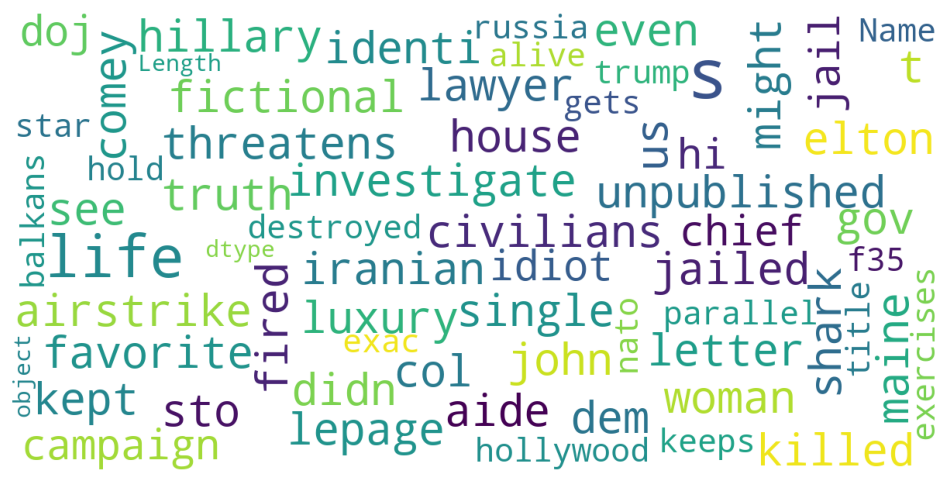

In [26]:
# Word cloud for corpus_title_fake
show_wordcloud(messages_fake['title'])

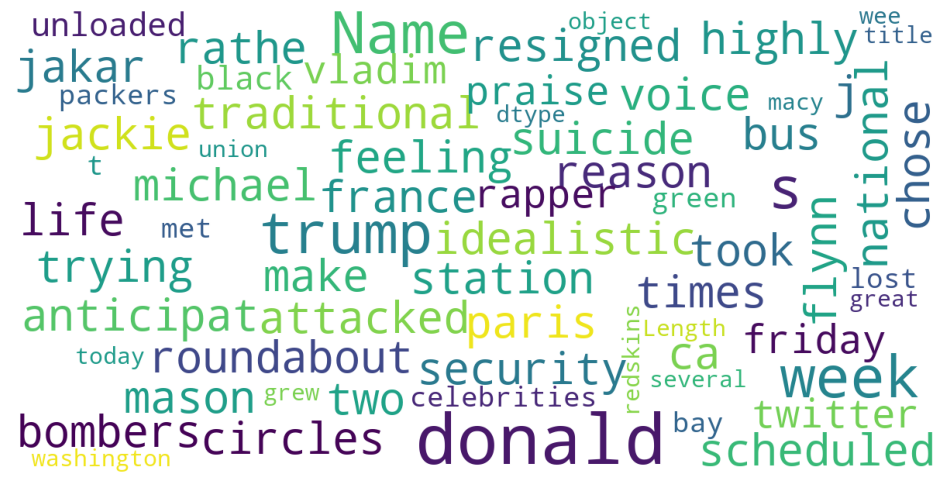

In [27]:
# Word cloud for corpus_title_not_fake
show_wordcloud(messages_not_fake['title'])

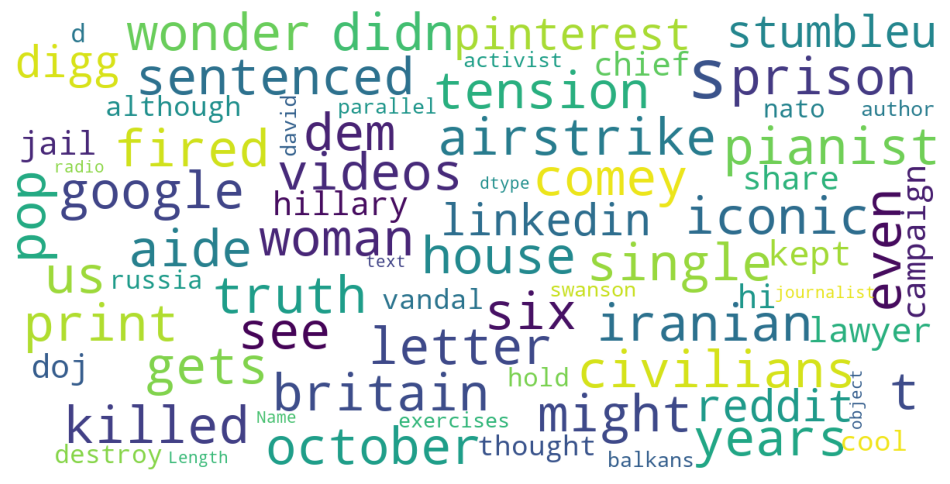

In [28]:
# Word cloud for corpus_text_fake
show_wordcloud(messages_fake['text'])

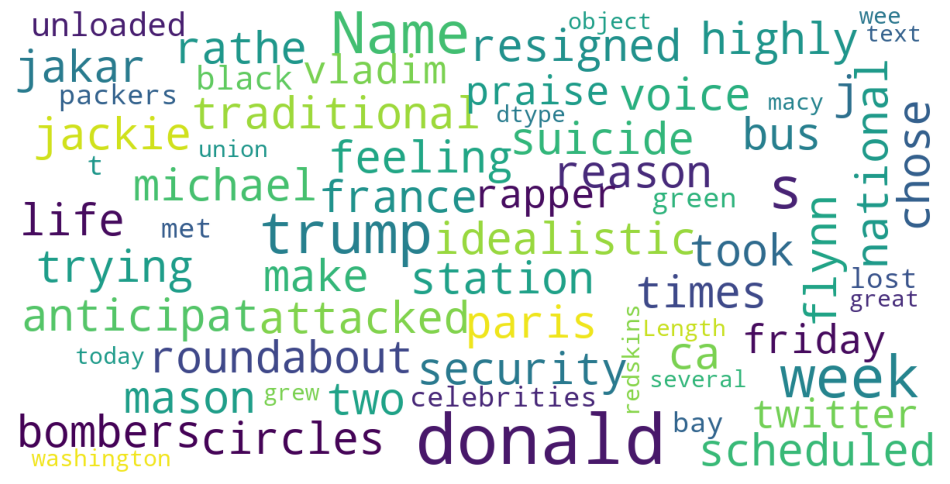

In [29]:
# Word cloud for corpus_text_not_fake
show_wordcloud(messages_not_fake['text'])